In [1]:
from google.colab import drive
import os
import sys

drive.mount('/content/drive')

PROJECT_PATH = '/content/drive/MyDrive/SVGEditor'
CODE_PATH = f"{PROJECT_PATH}/code"
MODEL_PATH = f"{PROJECT_PATH}/models"
RESOURCE_PATH = f"{PROJECT_PATH}/Resource"

if CODE_PATH not in sys.path:
    sys.path.insert(0, CODE_PATH)

# Single target processing
TARGET_NAME = "153_B"
ORIGINAL_PATH = f"{RESOURCE_PATH}/{TARGET_NAME}/Original"
INTERMEDIATE_FILES_PATH = f"{RESOURCE_PATH}/{TARGET_NAME}/IntermediateFiles"
COMPARISON_PATH = f"{RESOURCE_PATH}/{TARGET_NAME}/Comparison"
RESULT_PATH = f"{RESOURCE_PATH}/{TARGET_NAME}/Result"

# Input image file
INPUT_IMAGE = f"{ORIGINAL_PATH}/153_B.jpg"

# Vectorization input - the edited image from Qwen
VECTORIZATION_INPUT = f"{INTERMEDIATE_FILES_PATH}/153_B_qwen_edit.png"

Mounted at /content/drive


In [30]:
# Install dependencies (removed duplicates)
%pip install diffusers accelerate safetensors transformers huggingface_hub segment-anything opencv-python pillow matplotlib scikit-image scikit-learn cairosvg moviepy shapely networkx lxml

# Install vectorization dependencies
%pip install skan rdp

import shutil
import subprocess

# 1. Clean existing code directory and clone fresh repository
if os.path.exists(CODE_PATH):
    shutil.rmtree(CODE_PATH)

os.chdir(PROJECT_PATH)
result = subprocess.run(['git', 'clone', 'https://github.com/huanbasara/SVGEditor.git', 'code'],
                       capture_output=True, text=True)
print(f"Code repository {'successfully' if result.returncode == 0 else 'failed'} cloned")

# 2. Display latest commit information
os.chdir(CODE_PATH)
commit_info = subprocess.run(['git', 'log', '-1', '--pretty=format:%h|%ci|%s'],
                           capture_output=True, text=True)

if commit_info.returncode == 0:
    hash_code, commit_time, commit_msg = commit_info.stdout.strip().split('|', 2)
    print(f"Latest commit: {hash_code} ({commit_time.split()[0]}) - {commit_msg}")

# 3. Add code path to Python sys.path
if CODE_PATH not in sys.path:
    sys.path.insert(0, CODE_PATH)
    print(f"Added {CODE_PATH} to Python path")

# 4. Clear custom modules from cache
modules_to_clear = ['sam_processor', 'svglib', 'utils']

for base in modules_to_clear:
    to_remove = [m for m in sys.modules if m.startswith(base)]
    for m in to_remove:
        del sys.modules[m]

print("Modules reloaded!")

Code repository successfully cloned
Latest commit: 6e619a8 (2025-09-29) - update@2025-09-29 15:35:16
Modules reloaded!


=== Fill-to-Outline Processing ===
Loading image: /content/drive/MyDrive/SVGEditor/Resource/153_B/IntermediateFiles/153_B_qwen_edit.png
Original image shape: (960, 1088)
Binary threshold: 80
Processed 21 thick regions
Binary image saved: /content/drive/MyDrive/SVGEditor/Resource/153_B/IntermediateFiles/153_B_binary.png
Outline image saved: /content/drive/MyDrive/SVGEditor/Resource/153_B/IntermediateFiles/153_B_outline.png
✅ Processing completed successfully!


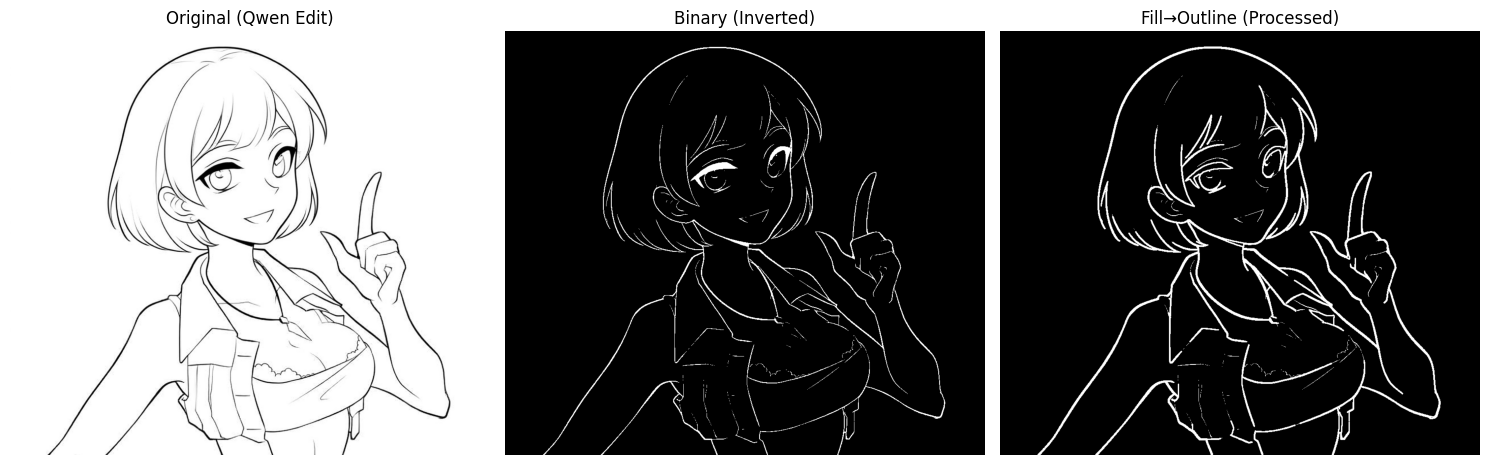

In [31]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
import os

# ==================== 可调参数 ====================
# 二值化参数
BINARY_THRESHOLD = 80  # 二值化阈值 (60-150, 越低保留细节越多)

# 厚度检测参数
THICKNESS_THRESHOLD = 3  # 厚度检测阈值 (2-5, 越小检测越敏感)
MIN_AREA = 100  # 最小面积过滤 (50-200, 过滤小噪声)

# 轮廓生成参数
OUTLINE_WIDTH = 2  # 轮廓线宽 (1-3, 生成的边框厚度)

# ==================== 核心函数 ====================

def convert_fills_to_outlines(binary_img):
    """将粗区域转换为边框线条（基于厚度检测）"""

    # 1. 识别连通组件
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_img)
    result_img = binary_img.copy()
    processed_count = 0

    for i in range(1, num_labels):  # 跳过背景标签0
        area = stats[i, cv2.CC_STAT_AREA]

        # 面积过滤
        if area < MIN_AREA:
            continue

        # 提取该组件
        component_mask = (labels == i).astype(np.uint8) * 255

        # 厚度检测
        if is_thick_region(component_mask, THICKNESS_THRESHOLD):
            # 生成边框
            outline_mask = create_outline_from_fill(component_mask)

            # 替换：移除原填充，添加边框
            result_img[labels == i] = 0  # 扣空操作
            result_img = cv2.bitwise_or(result_img, outline_mask)  # 添加边框
            processed_count += 1

    print(f"Processed {processed_count} thick regions")
    return result_img

def is_thick_region(component_mask, thickness_threshold):
    """使用形态学腐蚀检测区域厚度"""

    # 创建圆形kernel
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (thickness_threshold, thickness_threshold))

    # 腐蚀：只有厚度>=threshold的区域能存活
    eroded = cv2.erode(component_mask, kernel)

    # 如果腐蚀后还有残留，说明是粗区域
    return np.sum(eroded) > 0

def binarize_image(img):
    """二值化图像"""
    _, binary = cv2.threshold(img, BINARY_THRESHOLD, 255, cv2.THRESH_BINARY_INV)
    return binary

def create_outline_from_fill(fill_mask):
    """从填充区域生成边框"""

    # 查找轮廓
    contours, _ = cv2.findContours(fill_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    outline_mask = np.zeros_like(fill_mask)

    for contour in contours:
        # 绘制轮廓边框
        cv2.drawContours(outline_mask, [contour], -1, 255, thickness=OUTLINE_WIDTH)

    return outline_mask

def process_vectorization_input():
    """处理矢量化输入图像：填充区域转边框"""

    print(f"Loading image: {VECTORIZATION_INPUT}")

    # 检查文件是否存在
    if not os.path.exists(VECTORIZATION_INPUT):
        print(f"ERROR: Input file not found: {VECTORIZATION_INPUT}")
        return None

    # 加载图像
    img = cv2.imread(VECTORIZATION_INPUT, cv2.IMREAD_GRAYSCALE)
    print(f"Original image shape: {img.shape}")

    # 二值化
    binary = binarize_image(img)
    print(f"Binary threshold: {BINARY_THRESHOLD}")

    # 执行扣空处理
    outline_img = convert_fills_to_outlines(binary)

    # 保存结果
    os.makedirs(INTERMEDIATE_FILES_PATH, exist_ok=True)

    binary_path = os.path.join(INTERMEDIATE_FILES_PATH, f"{TARGET_NAME}_binary.png")
    outline_path = os.path.join(INTERMEDIATE_FILES_PATH, f"{TARGET_NAME}_outline.png")

    cv2.imwrite(binary_path, binary)
    cv2.imwrite(outline_path, outline_img)

    print(f"Binary image saved: {binary_path}")
    print(f"Outline image saved: {outline_path}")

    return outline_img

def visualize_processing_steps():
    """可视化处理步骤"""

    # 加载原图
    original = cv2.imread(VECTORIZATION_INPUT, cv2.IMREAD_GRAYSCALE)

    # 加载处理结果
    binary_path = os.path.join(INTERMEDIATE_FILES_PATH, f"{TARGET_NAME}_binary.png")
    outline_path = os.path.join(INTERMEDIATE_FILES_PATH, f"{TARGET_NAME}_outline.png")

    if os.path.exists(binary_path) and os.path.exists(outline_path):
        binary = cv2.imread(binary_path, cv2.IMREAD_GRAYSCALE)
        outline = cv2.imread(outline_path, cv2.IMREAD_GRAYSCALE)

        # 创建对比图
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(original, cmap='gray')
        axes[0].set_title('Original (Qwen Edit)')
        axes[0].axis('off')

        axes[1].imshow(binary, cmap='gray')
        axes[1].set_title('Binary (Inverted)')
        axes[1].axis('off')

        axes[2].imshow(outline, cmap='gray')
        axes[2].set_title('Fill→Outline (Processed)')
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print("Processed images not found. Please run process_vectorization_input() first.")

# ==================== 执行处理 ====================
print("=== Fill-to-Outline Processing ===")
outline_result = process_vectorization_input()

if outline_result is not None:
    print("✅ Processing completed successfully!")
    # 显示对比
    visualize_processing_steps()
else:
    print("❌ Processing failed!")
